<a href="https://colab.research.google.com/github/Mahdi-Miri/VIT/blob/main/Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Mahdi-Miri/VIT.git

fatal: destination path 'VIT' already exists and is not an empty directory.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras


# Load Image


In [ ]:
import requests

def download_image(url, filename):
  response = requests.get(url)
  with open(filename, 'wb') as f:
    f.write(response.content)

# Example usage:
url = "https://cdn-imgix.headout.com/media/images/16117e0116a542a5b0d10dd737f420f8-National%20Archaeological%20Museum%20of%20Naples.jpg?auto=format&w=702.4499999999999&h=401.4&q=90&fit=crop&ar=7%3A4&crop=faces"
filename = "downloaded_image.jpg"
download_image(url, filename)

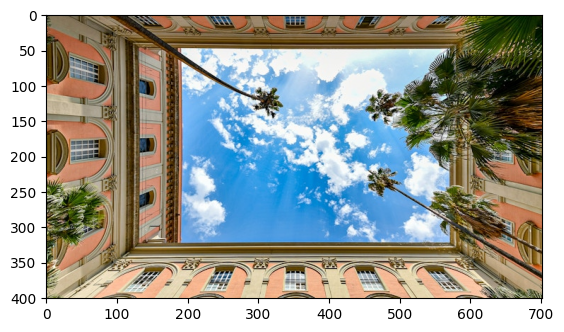

In [ ]:
img = plt.imread('downloaded_image.jpg')
plt.imshow(img)
plt.show()

In [ ]:
image  = tf.keras.preprocessing.image.load_img('downloaded_image.jpg',target_size=(144,144))

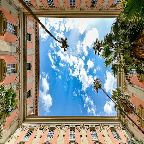

In [ ]:
image

# Convert Image

In [ ]:
print(image)

<PIL.Image.Image image mode=RGB size=144x144 at 0x796A87718EE0>


In [ ]:
from tensorflow.keras.utils import img_to_array
#ImageArray = tf.keras.preprocessing.img_to_array(image)
ImageArray = img_to_array(image)

In [ ]:
ImageArray

array([[[ 45.,  41.,  14.],
        [134., 118.,  95.],
        [134., 120.,  94.],
        ...,
        [ 15.,  35.,   7.],
        [ 18.,  41.,   0.],
        [ 28.,  43.,   0.]],

       [[113., 113.,  87.],
        [123., 112.,  84.],
        [133., 119.,  92.],
        ...,
        [ 18.,  43.,   4.],
        [ 15.,  40.,   0.],
        [ 17.,  33.,   0.]],

       [[ 41.,  40.,  19.],
        [131., 119.,  93.],
        [136., 120.,  95.],
        ...,
        [ 16.,  41.,   0.],
        [ 17.,  42.,   2.],
        [ 17.,  34.,   0.]],

       ...,

       [[203., 191., 149.],
        [209., 195., 158.],
        [199., 187., 149.],
        ...,
        [ 79.,  81.,  42.],
        [169., 165., 128.],
        [161., 153., 117.]],

       [[182., 172., 137.],
        [202., 194., 158.],
        [184., 180., 135.],
        ...,
        [118., 129.,  89.],
        [ 77.,  83.,  49.],
        [176., 183., 149.]],

       [[122., 120.,  79.],
        [110., 116.,  72.],
        [134., 1

In [ ]:
ImageArray = ImageArray[tf.newaxis, ...]

In [ ]:
print(ImageArray.shape)

(1, 144, 144, 3)


# Add Patch

In [ ]:
patches = tf.image.extract_patches(ImageArray ,sizes = [1,16,16,1],strides =[1,16,16,1],rates = [1,1,1,1],padding = "VALID" )

In [ ]:
print(patches.shape)

(1, 9, 9, 768)


In [ ]:
patches = tf.reshape(patches,shape=(tf.shape(patches)[0],-1,16*16*3))

In [ ]:
print(patches.shape)

(1, 81, 768)


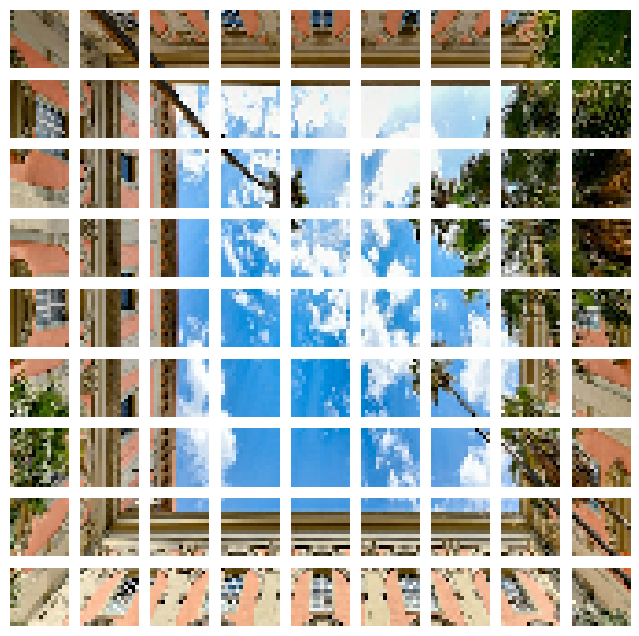

In [ ]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (8,8))

for i , patch in enumerate(patches[0]):
  ax = plt.subplot(n,n,i+1)
  patch_img = tf.reshape(patch,(16,16,3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis('off')

# Add layer

In [ ]:
class PatchEmbedding(tf.keras.layers.Layer):
  def __init__(self,size,num_of_patches,projection_dim):
    super().__init__()
    self.size = size
    self.num_of_patches = num_of_patches
    self.projection_dim =projection_dim
    self.projection = tf.keras.layers.Dense(projection_dim)
    self.positionalEmbedding = tf.keras.layers.Embedding(num_of_patches,projection_dim)
    self.clsToken = tf.Variable(tf.keras.initializers.GlorotUniform()(shape = (1,1,projection_dim)))
  def call(self,inputs):
      patches = tf.image.extract_patches(inputs,sizes = [1, self.size , self.size , 1],strides = [1,self.size , self.size,1], rates = [1,1,1,1],padding = "VALID")
      pathces = tf.reshape(patches , (tf.shape(inputs)[0] , -1 , self.size * self.size *3))
      patches = self.projection(patches)
      positions = tf.range(0, self.num_of_patches , 1)[tf.newaxis , ...]
      positionalEmbedding = self.positionalEmbedding(positions)
      patches = tf.reshape(patches, tf.shape(positionalEmbedding))
      patches = patches + positionalEmbedding
      return patches

In [ ]:
tf.range(0,81,1)[tf.newaxis , ...]

<tf.Tensor: shape=(1, 81), dtype=int32, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
        80]], dtype=int32)>

In [ ]:
embedding = PatchEmbedding(16,81,128)

In [ ]:
result = embedding(ImageArray)

In [ ]:
print(result.shape)

(1, 81, 128)
